## Part 1 Inspecting and selecting working light curve

* [exoplanet.eu](http://exoplanet.eu/catalog/CoRoT-5_b/)

Created: 10/20/2017

Last run:
* 10/20

In [1]:
!python --version

Python 3.6.1 :: Continuum Analytics, Inc.


In [2]:
import os
os.environ['CONDA_DEFAULT_ENV']

'astroconda35'

## import and parse csv

In [3]:
import glob
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline
#import multiprocessing

pl.style.use('seaborn-white')
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
pl.rcParams['ytick.labelsize'] = 'large'
pl.rcParams['xtick.labelsize'] = 'large'

In [4]:
import getpass
from tqdm import tqdm

data_dir = '.'
file_list=glob.glob(data_dir+'/*.dat')
file_list.sort()
len(file_list)

3

In [5]:
file_list[0]

'./msct0-CoRoT5b-170203-r25.0-t12-c7.dat'

## import lc

In [6]:
data={}
bands='g,r,z'.split(',')

for i,(f,b) in enumerate(zip(file_list,bands)):
    df=pd.read_csv(os.path.join(data_dir,f), delimiter=' ', parse_dates=True)
    df.columns='GJD-2450000,flux,err,airmass,sky,dx,dy,baserun,dummy'.split(',')
    #df = df.set_index('BJD(TDB)-2450000')
    df['GJD'] = df['GJD-2450000'].apply(lambda x: x+2450000)
    #df = df.set_index('GJD-2450000')
    df = df.set_index('GJD')
    try:
        df=df.drop(['dummy','baserun'],1)
    except:
        pass
    data[b]=df

In [7]:
df.head()

,GJD-2450000,flux,err,airmass,sky,dx,dy
GJD,,,,,,,
2.457788e+06,7787.907807,1.003087,0.003490,1.7579,1074.7,0.000,0.000
2.457788e+06,7787.909230,1.005691,0.003459,1.7412,1034.1,-0.534,1.534
2.457788e+06,7787.910666,1.004122,0.003387,1.7250,1005.7,-0.684,1.727
2.457788e+06,7787.912078,0.997404,0.003343,1.7093,981.6,-0.987,1.692
2.457788e+06,7787.913513,1.005262,0.003332,1.6940,945.2,-0.205,1.944


In [8]:
data[b].columns

Index(['GJD-2450000', 'flux', 'err', 'airmass', 'sky', 'dx', 'dy'], dtype='object')

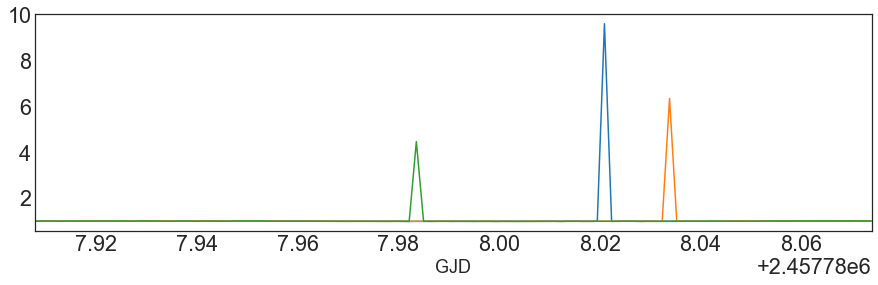

In [9]:
fig,ax = pl.subplots(1,1,figsize=(15,4))
for b in sorted(bands):
    df=data[b]
    df.flux.plot(label=b, ax=ax)

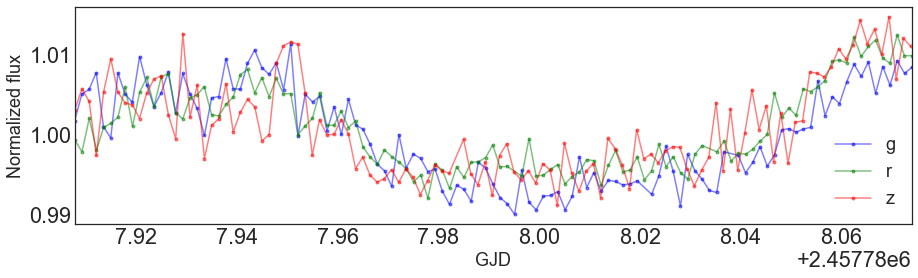

In [10]:
from astropy.stats import sigma_clip

outliers = {}
data2    = {} #outliers removed

colors='b,g,r'.split(',')
fig,ax = pl.subplots(1,1,figsize=(15,4))
for (b,c) in zip(sorted(bands),colors):
    df = data[b]
    #determine outliers
    fc = sigma_clip(df.flux, sigma_lower=10, sigma_upper=5)
    xc = sigma_clip(df.dx, sigma_lower=10, sigma_upper=5)
    yc = sigma_clip(df.dy, sigma_lower=10, sigma_upper=5)
    outliers[b] = (xc.mask | yc.mask | fc.mask)
    #remove outliers
    df2 = df[~outliers[b]]
    data2[b] = df2
    df2.flux.plot(label=b, marker='.', color=c, alpha=0.5, ax=ax)
    ax.set_ylabel('Normalized flux')
pl.legend()

## Save

In [11]:
for b in sorted(bands):
    fname='hatp20_QL_{}-band.csv'.format(b)
    data2[b].to_csv(fname)